In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
# Load Dataset (Use MNIST Dataset)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.60MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Define CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # channel 1 -> 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # channel 32 -> 64
        self.fc1 = nn.Linear(64 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, 10)  # output: class 10

    def forward(self, x):
        x = torch.relu(self.conv1(x))  # Conv1 + ReLU
        x = torch.relu(self.conv2(x))  # Conv2 + ReLU
        x = torch.flatten(x, 1)  # Flatten for fully connected layers
        x = torch.relu(self.fc1(x))  # Fully Connected Layer 1
        x = self.fc2(x)  # Fully Connected Layer 2
        return x

In [ ]:
# Initialization Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [ ]:
print(device)

cuda


In [ ]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=36864, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [ ]:
# Define FGSM attack function
def fgsm_attack(model, images, labels, epsilon):
    """
    Generate Adversarial Example with FSGM Attack
    """
    images.requires_grad = True  # Activation Gradient
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    perturbed_images = images + epsilon * data_grad.sign()  # Modification in the gradient direction
    perturbed_images = torch.clamp(perturbed_images, 0, 1)  # [0, 1]
    return perturbed_images


In [ ]:
# Define Adversarial Training Function
def adversarial_train(model, train_loader, criterion, optimizer, epsilon, epochs=5):
    """
    The model improves robustness by learning from both clean data and adversarial examples.
    """
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Step 1: Train Clean Data
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Step 2: Generate Adversarial Examples and Train
            perturbed_images = fgsm_attack(model, images, labels, epsilon)
            optimizer.zero_grad()
            outputs_adv = model(perturbed_images)
            loss_adv = criterion(outputs_adv, labels)
            loss_adv.backward()
            optimizer.step()

            epoch_loss += loss.item() + loss_adv.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

In [ ]:
# Test FSGM Attack
def test_attack(model, test_loader, epsilon=0.0):
    """
    Test the FGSM attack and evaluate the model's accuracy.
    """
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Generate Adversarial Examples
        if epsilon > 0:
            images = fgsm_attack(model, images, labels, epsilon)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total * 100
    print(f"Test Accuracy under epsilon={epsilon}: {accuracy:.2f}%")
    return accuracy


In [ ]:
# Train Clean Data(basic)
print("Training the model on normal data...")
for epoch in range(5):
    model.train()
    epoch_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/5], Loss: {epoch_loss:.4f}")

Training the model on normal data...
Epoch [1/5], Loss: 122.0105
Epoch [2/5], Loss: 31.9108
Epoch [3/5], Loss: 17.2397
Epoch [4/5], Loss: 12.1556
Epoch [5/5], Loss: 9.4464


In [ ]:
# Perform FGSM attack (before applying defense)
print("\nTesting the model under FGSM attack (no defense)...")
before = []
for ep in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    before.append(test_attack(model, test_loader, epsilon=ep))


Testing the model under FGSM attack (no defense)...
Test Accuracy under epsilon=0.0: 98.84%
Test Accuracy under epsilon=0.1: 91.68%
Test Accuracy under epsilon=0.2: 82.20%
Test Accuracy under epsilon=0.3: 67.90%
Test Accuracy under epsilon=0.4: 50.99%
Test Accuracy under epsilon=0.5: 38.09%
Test Accuracy under epsilon=0.6: 29.46%
Test Accuracy under epsilon=0.7: 24.82%
Test Accuracy under epsilon=0.8: 22.62%


In [ ]:
# CNN model VS After FGSM Attack model (epsilon = 0.1~0.3)
print("\nEvaluating the model on test data...")
test_accuracy = test_model(model, test_loader) # CNN
print(test_accuracy)
print(before[1:4])


Evaluating the model on test data...
Test Accuracy: 98.88%
98.88
[91.67999999999999, 82.19999999999999, 67.9]


In [ ]:
# Perform Adversarial Training
print("\nApplying Adversarial Training...")
adversarial_train(model, train_loader, criterion, optimizer, epsilon=0.1, epochs=5)


Applying Adversarial Training...
Epoch [1/5], Loss: 64.9968
Epoch [2/5], Loss: 24.8903
Epoch [3/5], Loss: 17.2154
Epoch [4/5], Loss: 14.5013
Epoch [5/5], Loss: 8.9595


In [ ]:
# Perform FGSM Attack (after applying defense)
print("\nTesting the model under FGSM attack (with Adversarial Training)...")
after = []
for ep in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    after.append(test_attack(model, test_loader, epsilon=ep))


Testing the model under FGSM attack (with Adversarial Training)...
Test Accuracy under epsilon=0.0: 98.88%
Test Accuracy under epsilon=0.1: 97.90%
Test Accuracy under epsilon=0.2: 96.33%
Test Accuracy under epsilon=0.3: 93.75%
Test Accuracy under epsilon=0.4: 90.52%
Test Accuracy under epsilon=0.5: 85.53%
Test Accuracy under epsilon=0.6: 78.34%
Test Accuracy under epsilon=0.7: 69.27%
Test Accuracy under epsilon=0.8: 60.31%


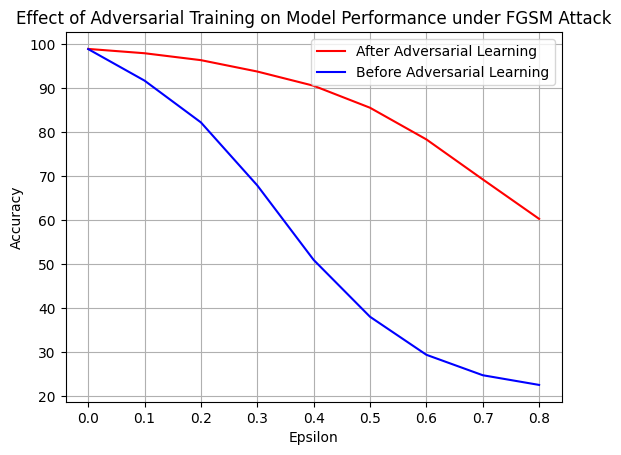

In [ ]:
import matplotlib.pyplot as plt

# Epsilon
epsilon_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

plt.plot(epsilon_values, after, 'r-', label='After Adversarial Learning')
plt.plot(epsilon_values, before, 'b-', label='Before Adversarial Learning')

plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Effect of Adversarial Training on Model Performance under FGSM Attack')

plt.legend()

plt.grid(True)
plt.show()

In [ ]:
print(before)
print(after)

[98.83999999999999, 91.67999999999999, 82.19999999999999, 67.9, 50.99, 38.09, 29.459999999999997, 24.82, 22.62]
[98.88, 97.89999999999999, 96.33, 93.75, 90.52, 85.53, 78.34, 69.27, 60.309999999999995]
